## Biblioteca

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

## Objetivo

Diferente de modelos como o de regressão linear simples que busca estimar uma função que explique uma variável quantitativa em função de uma ou mais variáveis explanatórias, o modelo de regressão logística busca estimar a probabilidade associada a eventos tais como ter uma doença, ocorrer um acidente ou uma falência (qualititativo). O objetivo deste estudo será aplicar o modelo regressão logística (logit) para mensurar a probabilidade de falência de uma companhia com base em seus indicadores financeiros. 

## Base de Dados

O dataset utilizado nesta análise é de companhias do mercado acionário de Taiwan do período de 1999 à 2009. 

link: https://archive.ics.uci.edu/dataset/572/taiwanese+bankruptcy+prediction

In [2]:
df = pd.read_csv(r"C:\Users\emanu\OneDrive\Área de Trabalho\bankrupcty.csv")
df

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [4]:
# Número de faLências (1) e não-falências (0)
df.iloc[:,0].value_counts()

Bankrupt?
0    6599
1     220
Name: count, dtype: int64

### Featuring

A escolha das variáveis explicativas foi baseado no paper Predicting Financial Distress Of Companies: Revisiting the Z-Score and ZETA® Models do Edward Altman onde ele faz uma revisão dos modelos Z-Score e Zeta para previsão de falência de companhias, no caso estamos usando como um referêncial teórico para a seleção das índices financeiros. Após vários testes realizados, as variáveis que não se mostraram estatísticamente significantes foram excluídas e ficamos com as três abaixo: 

In [5]:
# Correção do nome das variáveis que apresenta uma espaço no dataset original
df_adj = df.rename(columns={'Bankrupt?':'Bankrupt', 
                        ' Working Capital to Total Assets': 'Working Capital to Total Assets', # Liquidez Seca
                        ' Debt ratio %':'Debt Ratio', # Nível de Endividamento
                        ' ROA(A) before interest and % after tax': 'ROA'}) # Retorno sobre Ativos

# Seleção das variáveis em um dataframe separado, ele será ajustado depois para tratar os outliers. 
data_unadj = df_adj[['Bankrupt', 
               'Working Capital to Total Assets',
               'ROA', 
               'Debt Ratio']]

data_unadj.describe()

,Bankrupt,Working Capital to Total Assets,ROA,Debt Ratio
count,6819.000000,6819.000000,6819.000000,6819.000000
mean,0.032263,0.814125,0.558625,0.113177
std,0.176710,0.059054,0.065620,0.053920
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.774309,0.535543,0.072891
50%,0.000000,0.810275,0.559802,0.111407
75%,0.000000,0.850383,0.589157,0.148804
max,1.000000,1.000000,1.000000,1.000000


<Axes: >

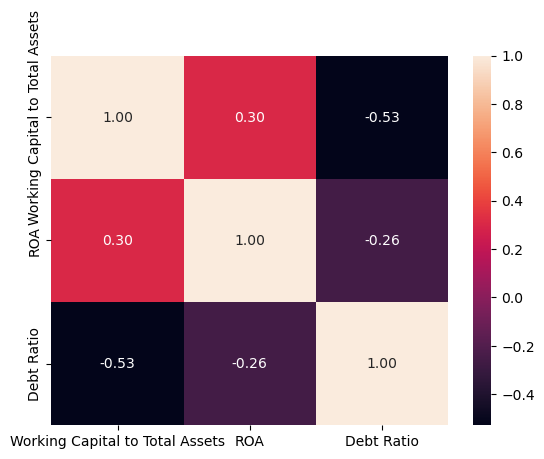

In [6]:
# Correlação entre as variáveis
sns.heatmap(data_unadj.iloc[:,1:].corr(), annot=True, fmt=".2f", annot_kws={'size': 10})

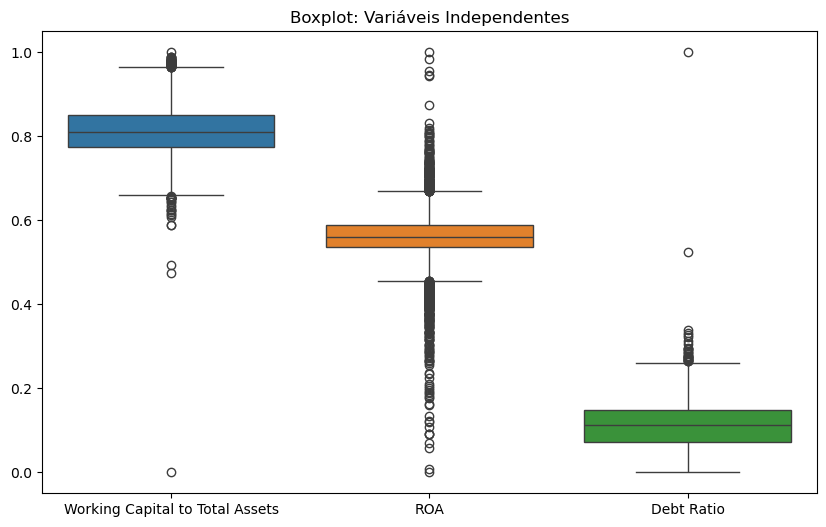

In [7]:
plt.figure(figsize=(10, 6))
sns.boxplot(data_unadj.iloc[:,1:])
plt.title('Boxplot: Variáveis Independentes')
plt.show()

### Filtragem

É possível vizualizar a presença de alguns outliers extremos que não fazem sentido e que provavelmente são erros de mensuração, fizemos uma leve filtração elimitando de 0.5% das observações. 

In [8]:
# Variáveis Independentes
X_ = data_unadj.iloc[:,1:]

# Caso seja preciso remover outliers
Q_Inf = data_unadj.iloc[:, 1:].quantile(0.001)
Q_Sup = data_unadj.iloc[:, 1:].quantile(0.999)

X_ = X_[(data_unadj.iloc[:, 1:] > Q_Inf) & (data_unadj.iloc[:, 1:] < Q_Sup)].dropna()

# Variáveis Dependentes
Y_ = data_unadj.iloc[:,0]

# Novo DataFrame
data = pd.concat([Y_, X_], axis=1).dropna()
data.describe()

,Bankrupt,Working Capital to Total Assets,ROA,Debt Ratio
count,6782.000000,6782.000000,6782.000000,6782.000000
mean,0.031259,0.814191,0.558992,0.113011
std,0.174030,0.057320,0.061995,0.052053
min,0.000000,0.615437,0.106629,0.002086
25%,0.000000,0.774373,0.535829,0.073163
50%,0.000000,0.810224,0.559911,0.111588
75%,0.000000,0.850146,0.589130,0.148638
max,1.000000,0.982663,0.820159,0.305378


In [9]:
print('Redução Observações:',round((len(Y_)-len(data['Bankrupt']))/len(data['Bankrupt']),3)*100,'%')

Redução Observações: 0.5 %


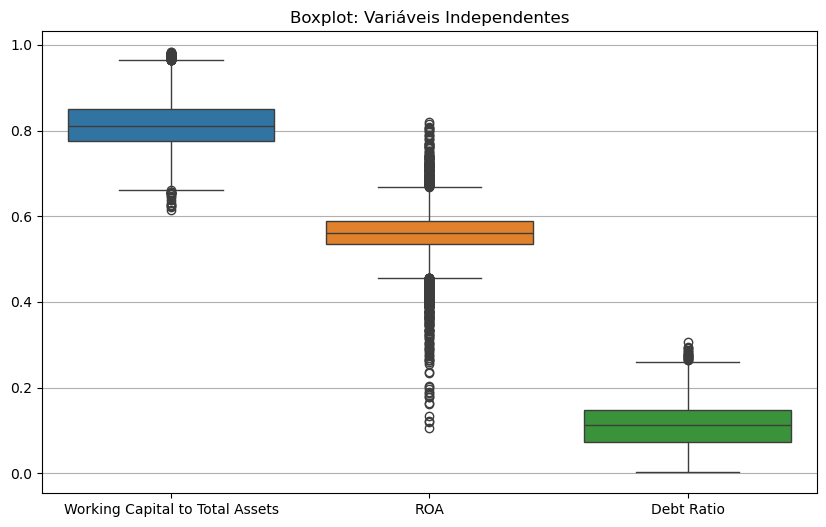

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(data.iloc[:,1:])
plt.title('Boxplot: Variáveis Independentes')
plt.grid(axis='y')
plt.show()

In [11]:
data['Bankrupt'].value_counts()

Bankrupt
0    6570
1     212
Name: count, dtype: int64

## Modelo Regressão Logística

Os modelos de regressão logística são apropriados para analisar variáveis qualitativas associadas a eventos e não-eventos, por exemplo, uma pessoa apresentar ou não problemas de saúde com base em seus hábitos alimentares. Na nossa base de dados temos uma relação de companhias que faliram e não faliram em um determinado período e seus respectivos índices financeiros (variável independente), buscaremos estimar a probabilidade de falência que é representado por uma variável do tipo $dummy$ (falência = 1 e não-falência = 0) com bases nestas outras variáveis quantitativas. 

A função de regressão logística pode ser expressa da seguinte forma: 

$$
P(Y = 1 | X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n)}}
$$

Onde Z é o logito e armazena os parâmetros $\beta$ da função. 

$$
Z = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n
$$

Diferente da regressão linear é estimada pelo método dos mínimos quadrados (OLS), na regressão logística é utilizada o método de máxima verossimilhança (MLE), os detalhes da estimação pode ser encontrado no livro Manual de Análise de Dados do Favero e Belfiori. 

In [12]:
# Intercepto
intercepto = pd.Series(1, index=data.index, name='Intercepto')

# Variável Independente
X = pd.concat([intercepto, data.iloc[:, 1:]], axis=1)
X

,Intercepto,Working Capital to Total Assets,ROA,Debt Ratio
0,1,0.672775,0.424389,0.207576
1,1,0.751111,0.538214,0.171176
2,1,0.829502,0.499019,0.207516
3,1,0.725754,0.451265,0.151465
4,1,0.751822,0.538432,0.106509
...,...,...,...,...
6814,1,0.817769,0.539468,0.124618
6815,1,0.793387,0.538269,0.099253
6816,1,0.866047,0.533744,0.038939
6817,1,0.832340,0.559911,0.086979


In [13]:
# Variável Dependente
Y = data.iloc[:,0]

# Modelo
modelo = sm.GLM(Y, X, family=sm.families.Binomial()).fit()

modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Bankrupt   No. Observations:                 6782
Model:                            GLM   Df Residuals:                     6778
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -632.55
Date:                Mon, 23 Sep 2024   Deviance:                       1265.1
Time:                        07:29:02   Pearson chi2:                 3.87e+03
No. Iterations:                     8   Pseudo R-squ. (CS):            0.08757
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercepto                          7.9498      1.488      5.342      0.000       5.033      10.867
Working Capital to Total Assets    -8.8696      1.668     -5.317      0.000     -12.139      -5.600
ROA                               -13.7379      1.101    -12.481      0.000     -15.895     -11.581
Debt Ratio                         18.9820      1.816     10.452      0.000      15.423      22.541
===================================================================================================
"""

### Teste $\chi^2$

O Teste $\chi^2$ nos mostra se ao menos uma das variáveis independentes foi estatísticamente significante para explicar a variável dependente. 

In [14]:
maximo = modelo.llf
minimo = modelo.llnull
qui2 = -2*(minimo - maximo)
pvalue = stats.distributions.chi2.sf(qui2,1)

print('Estatística Chi2:', qui2, 
      '\nP-Valor:', pvalue)

Estatística Chi2: 621.5478604226278 
P-Valor: 3.4443225996213183e-137


### Coeficientes

In [15]:
coeff = modelo.params
coeff

Intercepto                          7.949839
Working Capital to Total Assets    -8.869648
ROA                               -13.737938
Debt Ratio                         18.981977
dtype: float64

In [16]:
working_assets = 0.6
ROA = 0.4
debt_ratio = 0.15

z = (coeff[0] + coeff[1]*working_assets + coeff[2]*ROA + coeff[3]*debt_ratio)

print('Probabilidade de falência:', round(1/(1+np.exp(-z))*100, 2),'%')

Probabilidade de falência: 49.5 %


### Probabilidade Falências

In [17]:
data['phat'] = modelo.predict()
data['phat']

0       0.523116
1       0.054324
2       0.089156
3       0.140434
4       0.016403
          ...   
6814    0.012753
6815    0.009972
6816    0.001788
6817    0.004178
6818    0.000634
Name: phat, Length: 6782, dtype: float64

### Gráfico Sigmoide

O gráfico de sigmoide é um gráfico em formato de S que é oriundo de uma função de mesmo nome, nele podemos a probabilidade associada a variável dependente (1 e 0) em relação as variáveis explicativas. Por exemplo, podemos ver que as empresas que faliram (vermelho) estão associadas a um quick ratio e ROA mais baixos e também a um maior nível de endividamento, os pontos em laranja são as probabilidades que foram estimadas anteriormente. 

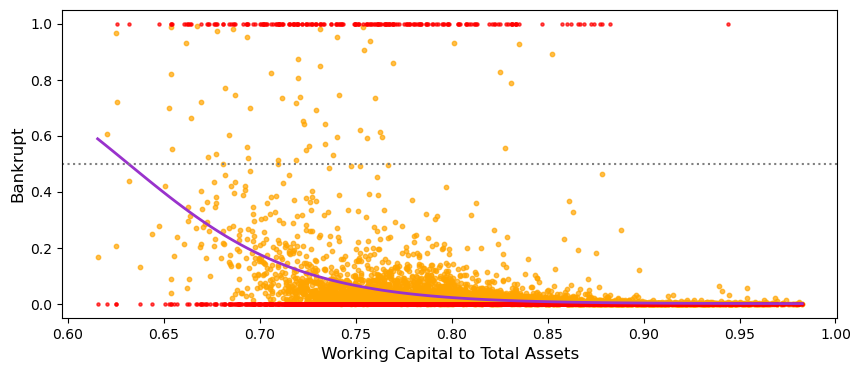

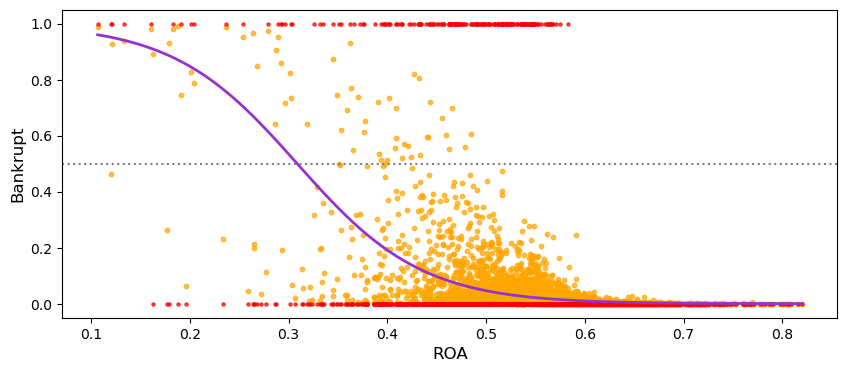

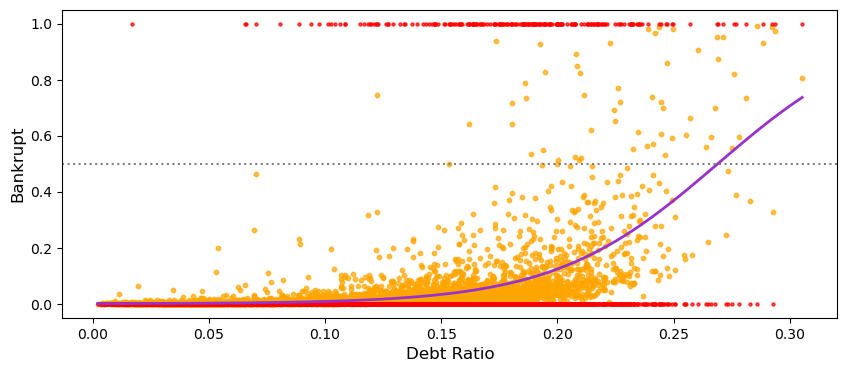

In [18]:
for x in X.iloc[:,1:]:
    plt.figure(figsize=(10,4))

    sns.regplot(x=data[x], y=data['phat'],
                ci=None, marker='o', logistic=True,
                scatter_kws={'color':'orange', 's':10, 'alpha':0.7},
                line_kws={'color':'darkorchid', 'linewidth':2})

    sns.regplot(x=data[x], y=data['Bankrupt'],
                ci=None, marker='o', logistic=True,
                scatter_kws={'color':'red', 's':5, 'alpha':0.7},
                line_kws={'color':'darkblue', 'linewidth':2, 'alpha':0})   

    plt.axhline(y = 0.5, color = 'grey', linestyle = ':')
    plt.xlabel(f'{x}', fontsize=12)
    plt.ylabel('Bankrupt', fontsize=12)

    plt.show

# Análise de Sensibilidade

De acordo com o modelo que construímos, há uma probabilidade associada a cada observação e esta probabilidade assume uma valor contínuo entre 0 e 1. Uma pergunta importante é: qual probabilidade assumimos como evento? Este valor de corte é chamado de cutoff.

### Exemplo: 

In [19]:
# y observado
y_obsv = data['Bankrupt']
y_obsv.value_counts()

Bankrupt
0    6570
1     212
Name: count, dtype: int64

In [20]:
from sklearn.metrics import confusion_matrix, classification_report

# y previsto
y = modelo.predict(X)

print('Cuttoff: 0.5')
print(pd.Series((y >= 0.5).astype(int)).value_counts())
print('\nCuttoff: 0.1')
print(pd.Series((y >= 0.1).astype(int)).value_counts())

Cuttoff: 0.5
0    6724
1      58
Name: count, dtype: int64

Cuttoff: 0.1
0    6359
1     423
Name: count, dtype: int64


No exemplo acima definimos um cuttoff de 0.5 e com base nele teriamos 32 companhias classificadas como falidas e com um cuttoff de 0.1 teriamos 369 companhias classificadas com falidas. No primeiro caso podemos ver que temos um número de companhias classificadas como falidas menor do que as que efetivamente faliram ($32<165$) e no outro caso a situação oposta ($369>165$). Entretanto falta uma informação importante, quanto destas previsão classificaram corretamente e quantas erroneamente? Esta pergunta pode ser respondida a partir do que é chamado de matriz de confusão. 

## Matriz de Confusão

A matriz de confusão demonstra com base no cuttoff definido a relação entre as observações corretamente classificadas e aquelas erroneamente classificadas, por exemplo, classificar quando evento quando realmente foi e como evento quando na verdade não foi. É intuitívo pensar que buscamos um modelo que classifique um evento somente quando ele ocorreu, vejamos como seria uma matriz de confusão para um cuttoff de 0.5: 

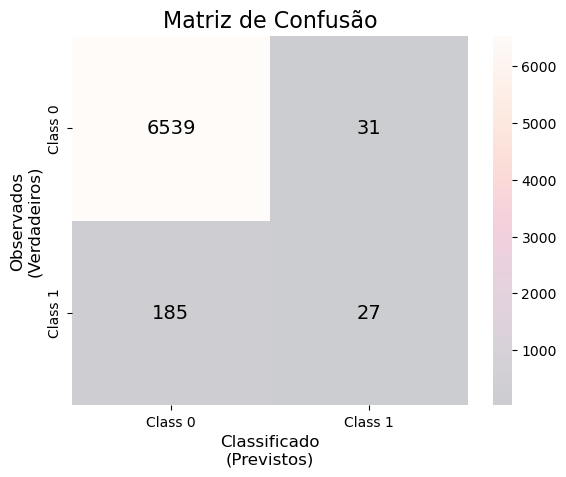

In [21]:
cuttoff = 0.5

y_pred = pd.Series((y >= cuttoff).astype(int))

plt.title('Matriz de Confusão', fontsize = 16)

sns.heatmap(confusion_matrix(y_obsv, y_pred), 
            annot=True, fmt='d', cmap=None, alpha=0.2,
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'],
            annot_kws={"size": 14, "color": "black"})

plt.xlabel('Classificado\n(Previstos)', fontsize = 12)
plt.ylabel('Observados\n(Verdadeiros)', fontsize = 12)

plt.show()

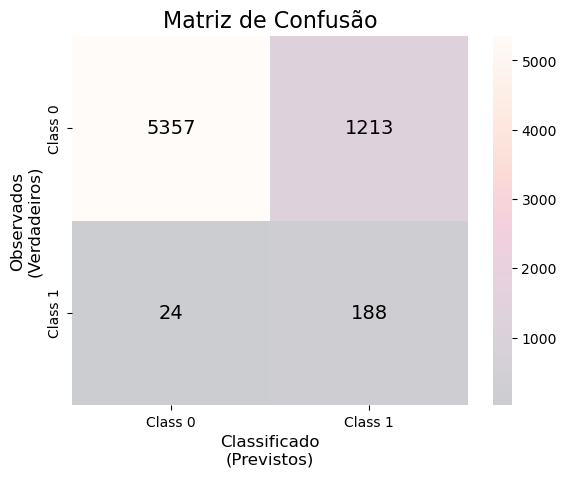

In [22]:
cuttoff = 0.03

y_pred = pd.Series((y >= cuttoff).astype(int))

plt.title('Matriz de Confusão', fontsize = 16)

sns.heatmap(confusion_matrix(y_obsv, y_pred), 
            annot=True, fmt='d', cmap=None, alpha=0.2,
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'],
            annot_kws={"size": 14, "color": "black"})

plt.xlabel('Classificado\n(Previstos)', fontsize = 12)
plt.ylabel('Observados\n(Verdadeiros)', fontsize = 12)

plt.show()

Podemos vizualizar que houve mais empresas que não faliram classificadas como faliram, isso significa que nossa classificação piorou? Não, depende do objetivo que você tenha, por exemplo, é melhor ter falsos positivos em um diagnóstico de cancer do que um falso negativo. Um segundo passo é criarmos estatísticas que podem nos ajudar a calcular a qualidade da nossa classificação.

### Indicadores:

- **Precision (Sensitividade)**: Proporção de acertos (1) em relação ao total de classificações (1). Mede o quão preciso foi as previsões (1), por exemplo, se você tem uma previsão de 1.00 significa que todas as classificações foram corretas. 

- **Recall (Especificidade)**: Proporção de acertos (1) em relação ao total de casos reais (1). Mede a capacidade de capturar todos as previsões (1), por exemplo, se você tem um recall de 1.00 significa que todas os eventos foram "capturados", mesmo que tenha havido classificações feitas incorretamente. 

- **Accuracy (Eficiência Global)**: Proporção de previsões corretas (1 e 0) em relação ao total de casos. Indica a taxa geral de acertos do modelo.

Obs. Pode-se trocar por 0 se você quer calcular a precisão da estimação de não-eventos, por exemplo. 

In [23]:
print(classification_report(y_obsv, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      6570
           1       0.13      0.89      0.23       212

    accuracy                           0.82      6782
   macro avg       0.56      0.85      0.56      6782
weighted avg       0.97      0.82      0.88      6782



Abaixo eu construí um gráfico que gera as estatísticas para o evento falência (1) com base diferentes cutoffs.

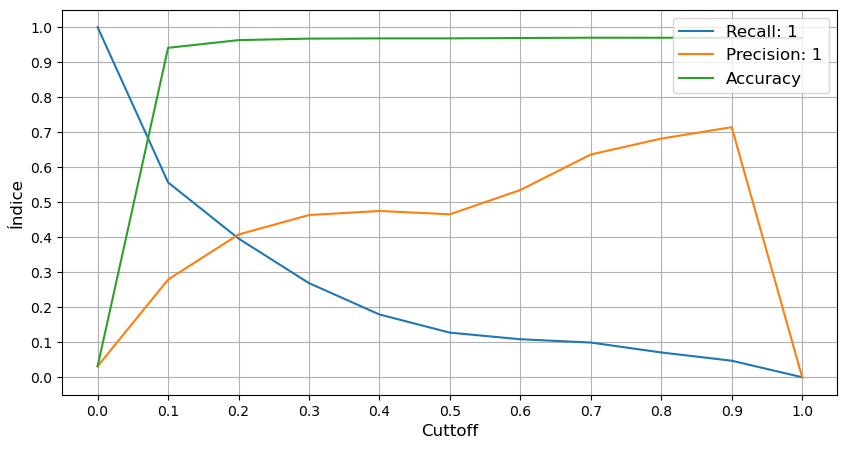

In [27]:
lista_cutoff = np.linspace(0,1,11)

lista_y = []
lista_recall = []
lista_precision = []
lista_accuracy = []

for c in lista_cutoff:
    y_ = pd.Series((y >= c).astype(int))
    lista_recall.append(classification_report(y_obsv, y_, zero_division=0, output_dict=True)['1']['recall'])
    lista_precision.append(classification_report(y_obsv, y_, zero_division=0, output_dict=True)['1']['precision'])
    lista_accuracy.append(classification_report(y_obsv, y_ , zero_division=0, output_dict=True)['accuracy'])

plt.figure(figsize=(10,5))

plt.plot(lista_cutoff, lista_recall, label = 'Recall: 1')
plt.plot(lista_cutoff, lista_precision, label = 'Precision: 1')
plt.plot(lista_cutoff, lista_accuracy, label = 'Accuracy')

plt.xlabel('Cuttoff', fontsize=12)
plt.ylabel('Índice', fontsize=12)
plt.xticks(np.arange(0, 1.1, 0.1), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=10)

plt.legend(loc='upper right', fontsize=12)
plt.grid()
plt.show()

Se quisermos com base neste modelo ter a segurança que estamos identificando todas as companhias que faliram mesmo que possa ter muitos falsos positivos, no caso, ser bastante conservador, podemos escolher cuttoffs entre 0 e 0.1. 

## Curva ROC (Receiver Operating Characteristic)

A curva ROC não depende do cuttoff definido pelo analista e permite avaliar a qualidade do ajuste do modelo como um todo, por meio dele podemos vizualizar o trade-off entre sensitividade e especificidade independente do cuttoff definido. A curva ROC pode ser aperfeiçoada na medida em que se seleciona melhores variáveis (featuring) para compor o modelo.  

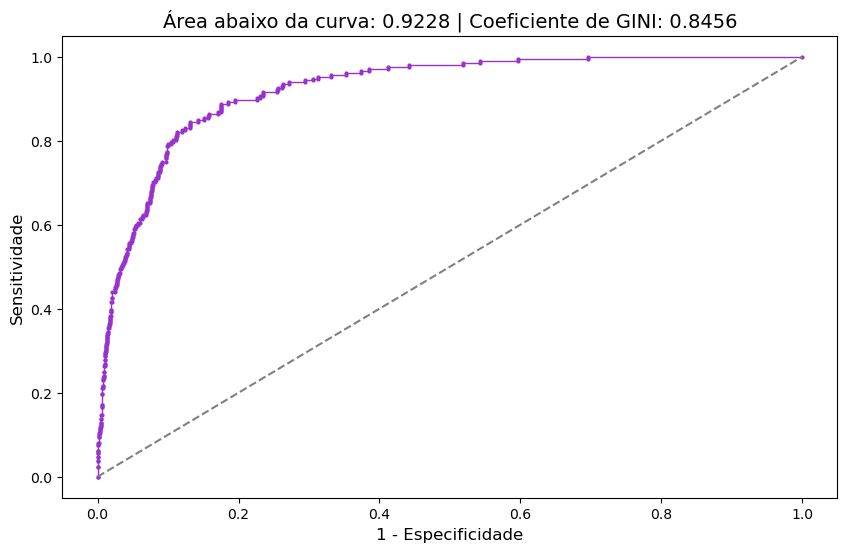

In [25]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(data['Bankrupt'], data['phat'])

roc_auc = auc(fpr, tpr)

gini = (roc_auc - 0.5)/(0.5)

plt.figure(figsize=(10,6))

plt.plot(fpr, tpr, marker='o', color='darkorchid', markersize=2, linewidth=1)
plt.plot(fpr, fpr, color='gray', linestyle='dashed')

plt.title('Área abaixo da curva: %g' % round(roc_auc, 4) +
          ' | Coeficiente de GINI: %g' % round(gini, 4), fontsize=14)

plt.xlabel('1 - Especificidade', fontsize=12)
plt.ylabel('Sensitividade', fontsize=12)
plt.xticks(np.arange(0, 1.1, 0.2), fontsize=10)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=10)

plt.show()